<div style='background-image: url("../../share/images/header.svg") ; padding: 0px ; background-size: cover ; border-radius: 5px ; height: 250px'>
    <div style="float: right ; margin: 50px ; padding: 20px ; background: rgba(255 , 255 , 255 , 0.7) ; width: 50% ; height: 150px">
        <div style="position: relative ; top: 50% ; transform: translatey(-50%)">
            <div style="font-size: xx-large ; font-weight: 900 ; color: rgba(0 , 0 , 0 , 0.8) ; line-height: 100%">Salvus</div>
            <div style="font-size: large ; padding-top: 20px ; color: rgba(0 , 0 , 0 , 0.5)">Sensitivity Kernels</div>
        </div>
    </div>
</div>

In [1]:
%matplotlib inline

# Import modules and setup paths.
import os
import h5py
import matplotlib.pyplot as plt
import pyasdf

# Paths are grabbed from environment variables.
PARAVIEW_BIN = os.environ["PARAVIEW_BIN"]
SALVUS_BIN = os.environ["SALVUS_BIN"]

# This is currently built together with Salvus.
MISFIT_BIN = os.path.join(os.path.dirname(SALVUS_BIN), 'compute_misfit')
MESH2D = 'Quad_IsotropicElastic2D_Nodal_44x44.e'

In this example we will use time reversal to simulate adjoint equations and to compute sensitivity kernels.

# Sensitivity kernels

The sensitivity kernel, i.e., the first derivative of the misfit functional with respect to the material parameters, indicate in which parts of the domain the misfit is sensitive to changes of the material parameters. In other words, the kernel tells us where we need to increase or decrease the model values to reduce the misfit.

At this stage we don't worry about designing a mesh from scratch, and will use a mesh that we have already used in the previous example together with the same source-receiver pair. First, we need to recreate the `toml` file to specify the source and receiver.

In [2]:
with open("salvus.toml", "w") as text_file:
    recLocX = 500
    recLoxY = 1000
    print("\n[[receiver]]", file=text_file)
    print("network = \"AB\"", file=text_file)
    print("station = \"CED\"", file=text_file)
    print("medium = \"solid\"", file=text_file)
    print("salvus_coordinates = [{0}, {1}]".format(recLocX, recLoxY), file=text_file)
    
    name = "source1"
    srcLocX = -500.0
    srcLocY = 1000.0
    spatial_type = "vector"
    temporal_type = "ricker"
    scaleX = 1e9
    scaleY = 1e9
    center_frequency = 14.5
    print("\n[[source]]", file=text_file)
    print("name = \"{0}\"".format(name), file=text_file)
    print("location = [{0}, {1}]".format(srcLocX, srcLocY), file=text_file)
    print("spatial_type = \"{0}\"".format(spatial_type), file=text_file)
    print("temporal_type = \"{0}\"".format(temporal_type), file=text_file)
    print("center_frequency = {0}".format(center_frequency), file=text_file)
    print("scale = [{0}, {1}]".format(scaleX,scaleY), file=text_file)

Adjoint methods are a powerful tool to compute sensitivities with respect to all kinds of parameters in PDE-constrained optimization problems. 

In this example we consider the isotropic elastic wave equation

$$
\rho\frac{\partial^2}{\partial t^2} u - \nabla \cdot \left(2\cdot \varepsilon(u) + \lambda(\nabla \cdot u) I\right) = f.
$$

So we have three parameters here, $\rho, \lambda$ and $\mu$, and the kernels are given by the following formulas:

$$
\begin{equation}\begin{aligned}K_{\rho} (\mathbf{x}) &= \int_0^T \frac{\partial^2}{\partial t^2} u(\mathbf{x},t) \cdot u^\dagger(\mathbf{x},t) \,dt,\\
K_{\lambda} (\mathbf{x}) &= \int_0^T (\nabla \cdot u(\mathbf{x},t)) \cdot(\nabla \cdot u^\dagger(\mathbf{x},t)) \,dt,\\
K_{\mu} (\mathbf{x}) &= \int_0^T \varepsilon(u)(\mathbf{x},t) : \varepsilon(u^\dagger)(\mathbf{x},t) \,dt.\end{aligned}\end{equation}
$$

Let's recall the steps we need to follow to compute a sensitivity kernel:
1. Run a forward simulation and store the wavefield
2. Compute the adjoint source(s)
3. Run an adjoint simulation and compute the kernel

**Which fields do we need to store during the forward simulation?** 

It can be tedious to keep track of that and Salvus takes care of saving the right fields automatically if you tell it to `--save-fields adjoint`. 

In [4]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 \
 --start-time -0.07 --end-time 0.91 --time-step 0.0007 \
 --source-toml salvus.toml \
 --receiver-toml salvus.toml --receiver-file-name receiver.h5 \
 --receiver-fields u_ELASTIC \
 --save-fields adjoint --save-wavefield-file wavefield.h5 \
 --absorbing-boundaries x0,x1,y0,y1


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Sub-optimal start time detected. This may cause high-frequency artefacts in the simulation. Suggested start time would is -0.107544.
Timestep set by user as: 0.0007 s.
Automated timestep would be set to: 0.000735822 s.
Sub-optimal start time detected. This may cause high-frequency artefacts in the simulation. Suggested start time would is -0.107544.
Begin time loop.
Time loop progress [100%].
Time loop completed in 11.0479 seconds.
Begin post processing.
Problem complete.



Note that we need to set `--start-time`, `--end-time` and the `--time-step` explicitly to make sure we can use the same discretization for the adjoint run again. Check the contents of the `hdf5` file to find out which fields Salvus saved.

In [5]:
!h5ls -vr wavefield.h5

Opened "wavefield.h5" with sec2 driver.
/                        Group
    Location:  1:96
    Links:     1
/ELASTIC                 Group
    Location:  1:800
    Links:     1
/ELASTIC/connectivity    Dataset {30976/30976, 4/4}
    Location:  1:777760
    Links:     1
    Storage:   495616 logical bytes, 495616 allocated bytes, 100.00% utilization
    Type:      native int
/ELASTIC/coordinates     Dataset {1936/1936, 25/25, 2/2}
    Location:  1:1832
    Links:     1
    Storage:   774400 logical bytes, 774400 allocated bytes, 100.00% utilization
    Type:      native double
/ELASTIC/data            Dataset {1401/1401, 1936/1936, 5/5, 25/25}
    Attribute: DIMENSION_LABELS {4}
        Type:      variable-length null-terminated ASCII string
        Data:  "time", "element",
               "[ a_ELASTIC_CMP_X | a_ELASTIC_CMP_Y | strain_CMP_XX | strain_CMP_YY | strain_CMP_XY ]",
               "point"
    Location:  1:777144
    Links:     1
    Storage:   2712336000 logical bytes, 271233

Next, we need to compute the adjoint sources. In this simple example we do not consider observed data to compare with our synthetics, but just try to minimize the following misfit functional

$$
\frac{1}{2}\int_0^T u(\mathbf{x}_{r},t)^2 \,dt,
$$

which is some form of ''energy norm''. The sensitivity with respect to the material parameters will show which parts of the domain influence the amount energy that is propagated to the receiver location.
The adjoint source is the negative Frechet derivative of the misfit functional with respect to the displacement, which - in this simple case - is just the displacement with a flipped sign, i.e., $-u(\mathbf{x}_{r},t)$. 

Execute the following line to compute the misfit and the adjoint source for this example:

In [41]:
import pathlib
import toml
import numpy as np
def compute_misfit_and_adjoint_sources(receiver_toml_file: pathlib.Path,
                                       synthetic_asdf_file: pathlib.Path,
                                       adjoint_source_asdf_file: pathlib.Path,
                                       adjoint_source_toml_file: pathlib.Path):
    """
    Computes the misfit and adjoint sources for the given ASDF file containing
    synthetic data.

    :param receiver_toml_file: The receiver toml file.
    :param synthetic_asdf_file: The ASDF file with the synthetic data.
    :param adjoint_source_file: The output ASDF file with the adjoint
        source. Must not exist yet.
    :param adjoint_source_toml_file: The accompanying source TOML file so
        Salvus can actually use the adjoint source in the ASDF file. Must not
        exist yet.
    """

    assert receiver_toml_file.exists(), receiver_toml_file
    assert synthetic_asdf_file.exists(), synthetic_asdf_file    
    if adjoint_source_asdf_file.exists():
        os.remove(adjoint_source_asdf_file)
    if adjoint_source_toml_file.exists():
        os.remove(adjoint_source_toml_file)

    misfit = 0.0
    sources = []

    recToml = toml.load(str(receiver_toml_file))
                  
    with pyasdf.ASDFDataSet(str(synthetic_asdf_file)) as ds_in, \
         pyasdf.ASDFDataSet(str(adjoint_source_asdf_file)) as ds_out:

        for station in ds_in.waveforms:
            station_name = station._station_name.replace(".", "_")

            for rec in recToml["receiver"]:
                rec_name = rec.get("network") + "_" + rec.get("station")
                if (rec_name == station_name):
                    loc = rec.get("salvus_coordinates")
           
            tr1 = (station.displacement[0])
            tr2 = (station.displacement[1])

            adj_src = np.empty((tr1.stats.npts,2))
 
            misfit += tr1.stats.delta * ((tr1.data) ** 2).sum()
            misfit += tr2.stats.delta * ((tr2.data) ** 2).sum()            
            adj_src[:,0] = -tr1.stats.delta * (tr1.data[::-1]) 
            adj_src[:,1] = -tr2.stats.delta * (tr2.data[::-1])            
  
            ds_out.add_auxiliary_data(
                   data=adj_src,
                   data_type="AdjointSources",
                   path=station_name,
                   parameters={
                       "dt": tr1.stats.delta,
                       "starttime": float(tr1.stats.starttime),
                       "location": [float(loc[0]), float(loc[1])],
                       "spatial-type": np.string_(b"vector\x00")})

            ds_name = "/AuxiliaryData/AdjointSources/" + station_name
            sources.append({"name": station_name,
                            "dataset_name": ds_name})                


    with open(str(adjoint_source_toml_file), "wt") as fh:
        toml.dump({"source_input_file": str(adjoint_source_asdf_file.absolute()),"source": sources}, fh)


    return (0.5*misfit)

In [42]:
receiver_toml_file = pathlib.Path('salvus.toml')
synthetic_asdf_file = pathlib.Path('receiver.h5')
adjoint_source_asdf_file = pathlib.Path('adjointSource.h5')
adjoint_source_toml_file = pathlib.Path('adjointSource.toml')

misfit = compute_misfit_and_adjoint_sources(receiver_toml_file, 
                                            synthetic_asdf_file, 
                                            adjoint_source_asdf_file, 
                                            adjoint_source_toml_file)

print(misfit)

1.87591130751e-07


Let's check the contents of the two files that have been created.

In [43]:
! h5ls -vr adjointSource.h5

Opened "adjointSource.h5" with sec2 driver.
/                        Group
    Attribute: file_format scalar
        Type:      5-byte null-padded ASCII string
        Data:  "ASDF\000"
    Attribute: file_format_version scalar
        Type:      6-byte null-padded ASCII string
        Data:  "1.0.0\000"
    Location:  1:96
    Links:     1
/AuxiliaryData           Group
    Location:  1:2696
    Links:     1
/AuxiliaryData/AdjointSources Group
    Location:  1:3400
    Links:     1
/AuxiliaryData/AdjointSources/AB_CED Dataset {1401/Inf, 2/Inf}
    Attribute: dt scalar
        Type:      native double
        Data:  0.0007
    Attribute: location {2}
        Type:      native double
        Data:  500, 1000
    Attribute: spatial-type scalar
        Type:      7-byte null-padded ASCII string
        Data:  "vector\000"
    Attribute: starttime scalar
        Type:      native double
        Data:  -0.07
    Location:  1:4432
    Links:     1
    Chunks:    {701, 2} 11216 bytes
    Stor

There is a `hdf5` file that contains the adjoint sources and a `toml` file that we can use as input for the adjoint simulation. The `toml` file specifies the `source_input_file` where the adjoint traces are stored as well as the location (groups and datasets) in this file. Location, spatial type and time are stored directly in the `hdf5` file.

In [44]:
!cat adjointSource.toml

source_input_file = "/home/boehm/SalvusInc/SalvusExamples/tutorials/6_Sensitivity_Kernel/adjointSource.h5"
[[source]]
name = "AB_CED"
dataset_name = "/AuxiliaryData/AdjointSources/AB_CED"


Next, we should take a look at the adjoint sources. Plot them with `pyasdf`, but remember that they are not stored as `Waveforms`, but in the group `AuxiliaryData`.

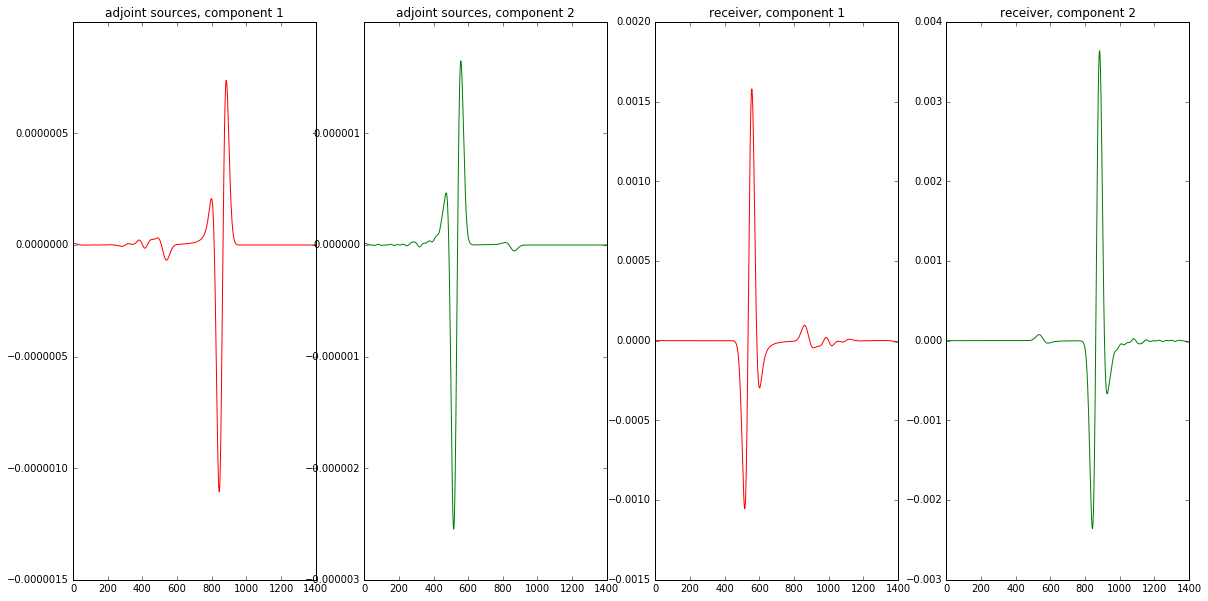

In [45]:
with pyasdf.ASDFDataSet("adjointSource.h5") as ds_adjSrc, \
        pyasdf.ASDFDataSet("receiver.h5") as ds_rec:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(20,10))
    ax1.plot(ds_adjSrc.auxiliary_data.AdjointSources["AB_CED"].data[:,0], color="red")
    ax1.set_title('adjoint sources, component 1')
    ax2.plot(ds_adjSrc.auxiliary_data.AdjointSources["AB_CED"].data[:, 1], color="green")
    ax2.set_title('adjoint sources, component 2')
    ax3.plot(ds_rec.waveforms.AB_CED.displacement.select(component="X")[0].data, color="red")
    ax3.set_title('receiver, component 1')
    ax4.plot(ds_rec.waveforms.AB_CED.displacement.select(component="Y")[0].data, color="green")
    ax4.set_title('receiver, component 2')

**Did you notice that the amplitudes are different? Do you know why this is the case?**

After discretizing the problem, the discrete misfit looks as follows:

$$
\frac{1}{2}\int_0^T u(\mathbf{x}_{r},t)^2 \,dt \approx \frac{\Delta t}{2}\sum_{i=0}^{N_t} u(\mathbf{x}_{r},t_i)^2, 
$$ 

so the partial derivative with respect to $u(\mathbf{x}_{r},t_i)$ is $\Delta t \cdot u(\mathbf{x}_{r},t_i)$.



Ok, almost there. Now we only need to run the adjoint simulation. First we need to tell Salvus, that we want to run a simulation in adjoint mode by setting `--adjoint true`. Next, we specify the adjoint source with the `toml` file we created. And finally, we need to tell Salvus to load the forward wavefield and the name of the file to which it should write the kernel using the following options:

`--load-wavefield-file wavefield.h5 --load-fields adjoint --kernel-file kernel.e`

In [46]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 \
 --start-time -0.07 --end-time 0.91 --time-step 0.0007 \
 --source-toml adjointSource.toml \
 --adjoint true \
 --load-wavefield-file wavefield.h5 --load-fields adjoint --kernel-file kernel.e \
 --absorbing-boundaries x0,x1,y0,y1


Salvus version 0.0.1-974-g7237b8b
Floating point size: 64
Compiled for GLL orders: 4
Running on 1 rank(s).

Initializing problem.
Timestep set by user as: 0.0007 s.
Automated timestep would be set to: 0.000735822 s.
Begin time loop.
Time loop progress [100%].
Time loop completed in 7.27099 seconds.
Begin post processing.
Problem complete.



Are you excited how the kernel will look like?

In [47]:
!$PARAVIEW_BIN kernel.e

The kernel lives in the same vector space as the model so it is stored in the same format. By default, Salvus computes the derivatives with respect to the parameters that enter linearly into the wave equation. But maybe you are interested in the $v_p$- and $v_s$-kernel instead? OK, we can do that to. Just use the option `--kernel-fields RHO,VP,VS` to compute the kernels using this parameterization.

In [ ]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 \
 --start-time -0.07 --end-time 0.91 --time-step 0.0007 \
 --source-toml adjointSource.toml \
 --adjoint true \
 --load-wavefield-file wavefield.h5 --load-fields adjoint --kernel-file kernel.e \
 --kernel-fields RHO,VP,VS \
 --absorbing-boundaries x0,x1,y0,y1

Now take a look at the new kernel file.

In [ ]:
!$PARAVIEW_BIN kernel.e

Are you wondering how the kernel evolves over time? You can visualize it easily if you tell Salvus to save the wavefield during the adjoint simulation. Run the adjoint simulation again and store the displacement and the time-dependent kernel which can be accessed with `--save-fields gradient`. Just make sure to write to a different file, `wavefield.h5` is already taken.

In [ ]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
--polynomial-order 4 --dimension 2 \
--start-time -0.07 --end-time 0.91 --time-step 0.0007 \
--source-toml adjointSource.toml \
--adjoint true \
--load-wavefield-file wavefield.h5 --load-fields kernel --kernel-file kernel.e \
--save-wavefield-file wavefield_adj.h5 --save-fields u_ELASTIC,gradient \
--kernel-fields RHO,VP,VS \
--absorbing-boundaries x0,x1,y0,y1

Open the `xdmf` file to plot how the adjoint wavefield and the gradient evolves over time.

In [ ]:
!$PARAVIEW_BIN wavefield_adj_ELASTIC.xdmf

Now redo the example but this time with a free surface (i.e., no absorbing condition at `y1`).

In [ ]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 \
 --start-time -0.07 --end-time 0.91 --time-step 0.0007 \
 --source-toml salvus.toml \
 --receiver-toml salvus.toml --receiver-file-name receiver.h5 --receiver-fields u_ELASTIC \
 --save-fields adjoint --save-wavefield-file "wavefield.h5" \
 --absorbing-boundaries x0,x1,y0

!$MISFIT_BIN salvus.toml receiver.h5 adjoint

!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 \
 --start-time -0.07 --end-time 0.91 --time-step 0.0007 \
 --source-toml adjointSource.toml \
 --adjoint true \
 --load-wavefield-file wavefield.h5 --load-fields adjoint --kernel-file kernel.e \
 --save-wavefield-file wavefield_adj.h5 --save-fields u_ELASTIC \
 --absorbing-boundaries x0,x1,y0

In [ ]:
!$PARAVIEW_BIN kernel.e

Not only the kernel looks different but also the misfit increased, because due to the reflecting surface, more energy is now propagated to the receiver. Have a look at the seismograms and adjoint sources.

In [ ]:
with pyasdf.ASDFDataSet("adjointSource.h5") as ds_adjSrc, \
        pyasdf.ASDFDataSet("receiver.h5") as ds_rec:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(20,10))
    ax1.plot(ds_adjSrc.auxiliary_data.AdjointSources["AB.CED"].data[:, 0], color="red")
    ax1.set_title('adjoint sources, component 1')
    ax2.plot(ds_adjSrc.auxiliary_data.AdjointSources["AB.CED"].data[:, 1], color="green")
    ax2.set_title('adjoint sources, component 2')
    ax3.plot(ds_rec.waveforms.AB_CED.displacement.select(component="X")[0].data, color="red")
    ax3.set_title('receiver, component 1')
    ax4.plot(ds_rec.waveforms.AB_CED.displacement.select(component="Y")[0].data, color="green")
    ax4.set_title('receiver, component 2')

You can see the arrival of the second wave, which explains why the kernel looks different. Now try to restrict the misfit only to the first arrival. You can call the misfit tool with the following arguments

`<receiver toml> <receiver hdf5> <misfit start time> <misfit end time> adjoint`

In [ ]:
!$MISFIT_BIN salvus.toml receiver.h5 0.0 0.4 adjoint

The misfit is significantly smaller and the adjoint sources changed, too.

In [ ]:
with pyasdf.ASDFDataSet("adjointSource.h5") as ds_adjSrc, \
        pyasdf.ASDFDataSet("receiver.h5") as ds_rec:
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=False, figsize=(20,10))
    ax1.plot(ds_adjSrc.auxiliary_data.AdjointSources["AB.CED"].data[:, 0], color="red")
    ax1.set_title('adjoint sources, component 1')
    ax2.plot(ds_adjSrc.auxiliary_data.AdjointSources["AB.CED"].data[:, 1], color="green")
    ax2.set_title('adjoint sources, component 2')
    ax3.plot(ds_rec.waveforms.AB_CED.displacement.select(component="X")[0].data, color="red")
    ax3.set_title('receiver, component 1')
    ax4.plot(ds_rec.waveforms.AB_CED.displacement.select(component="Y")[0].data, color="green")
    ax4.set_title('receiver, component 2')

Next, we need to run the adjoint simulation again and check the new kernel.

In [ ]:
!$SALVUS_BIN --mesh-file $MESH2D --model-file $MESH2D \
 --polynomial-order 4 --dimension 2 \
 --start-time -0.07 --end-time 0.91 --time-step 0.0007 \
 --source-toml adjointSource.toml \
 --adjoint true \
 --load-wavefield-file wavefield.h5 --load-fields adjoint --kernel-file kernel.e \
 --save-wavefield-file wavefield_adj.h5 --save-fields u_ELASTIC \
 --kernel-fields RHO,VP,VS \
 --absorbing-boundaries x0,x1,y0

In [ ]:
!$PARAVIEW_BIN kernel.e

### Ente gut, alles gut.